In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
import os
import matplotlib.pyplot as plt 

In [10]:
DROPPED = [
    "dist_360_SPEED", "dist_360_THROTTLE", "dist_360_STEER", "dist_360_BRAKE",
    "dist_360_CURRENTLAPTIMEINMS", "dist_360_LAPDISTANCE", "dist_360_WORLDPOSITIONX", "dist_360_WORLDPOSITIONY",
    "dist_360_WORLDFORWARDDIRX", "dist_360_WORLDFORWARDDIRY", "dist_360_YAW", "dist_360_PITCH",
    "dist_360_ROLL", "dist_360_left_dist", "dist_360_right_dist", "dist_360_dist_apex_1",
    "dist_360_dist_apex_2", "dist_360_angle_to_apex1", "dist_360_angle_to_apex2", "dist_360_proj_from_ref",
    "dist_430_SPEED", "dist_430_THROTTLE", "dist_430_STEER", "dist_430_BRAKE",
    "dist_430_CURRENTLAPTIMEINMS", "dist_430_LAPDISTANCE", "dist_430_WORLDPOSITIONX", "dist_430_WORLDPOSITIONY",
    "dist_430_WORLDFORWARDDIRX", "dist_430_WORLDFORWARDDIRY", "dist_430_YAW", "dist_430_PITCH",
    "dist_430_ROLL", "dist_430_left_dist", "dist_430_right_dist", "dist_430_dist_apex_1",
    "dist_430_dist_apex_2", "dist_430_angle_to_apex1", "dist_430_angle_to_apex2", "dist_430_proj_from_ref",
    "dist_530_SPEED", "dist_530_THROTTLE", "dist_530_STEER", "dist_530_BRAKE",
    "dist_530_CURRENTLAPTIMEINMS", "dist_530_LAPDISTANCE", "dist_530_WORLDPOSITIONX", "dist_530_WORLDPOSITIONY",
    "dist_530_WORLDFORWARDDIRX", "dist_530_WORLDFORWARDDIRY", "dist_530_YAW", "dist_530_PITCH",
    "dist_530_ROLL", "dist_530_left_dist", "dist_530_right_dist", "dist_530_dist_apex_1",
    "dist_530_dist_apex_2", "dist_530_angle_to_apex1", "dist_530_angle_to_apex2", "dist_530_proj_from_ref",
    "BPS_right_dist", "BPE_right_dist", "THS_right_dist", "THE_right_dist", "STS_right_dist",
    "STM_right_dist", "STE_right_dist", "APX1_right_dist", "APX2_right_dist", "BPS_CURRENTLAPTIMEINMS",
    "BPE_CURRENTLAPTIMEINMS", "THS_CURRENTLAPTIMEINMS", "THE_CURRENTLAPTIMEINMS", "STS_CURRENTLAPTIMEINMS",
    "STM_CURRENTLAPTIMEINMS", "STE_CURRENTLAPTIMEINMS", "APX1_CURRENTLAPTIMEINMS", "APX2_CURRENTLAPTIMEINMS"
]

# Uploading Data and removing outliers and features

In [11]:
os.chdir(r"c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001\Data3001-Modelling-2")
data = pd.read_csv("final_data_product.csv")
data = data.dropna().drop_duplicates().drop(columns=DROPPED).sort_values(by="Target_CURRENTLAPTIMEINMS")
target_mean = data["Target_CURRENTLAPTIMEINMS"].mean()
target_std = data["Target_CURRENTLAPTIMEINMS"].std()
data = data[data['Target_CURRENTLAPTIMEINMS'] < target_mean + 3 * target_std] # removes 12 longest times
y = data["Target_CURRENTLAPTIMEINMS"]
X = data.drop(columns=["Target_CURRENTLAPTIMEINMS", "lap_id", "invalid_lap"])

target_columns = [
    'target_CURRENTLAPTIMEINMS', '_LAPDISTANCE', '_WORLDPOSITIONX', 
    '_STEER', '_BRAKE', '_THROTTLE', '_WORLDPOSITIONY'
]

selected_columns = [col for col in X.columns if col.endswith(tuple(target_columns))]
X = X[selected_columns]

# target_points = [
#     'BPS', 'BPE'
# ]

# selected_columns = [col for col in X.columns if col.startswith(tuple(target_points))]
# X = X[selected_columns]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

scaler_X = StandardScaler()
scaler_X_split = StandardScaler()
scaler_y = StandardScaler()
scaler_y_split = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
X_train_scaled = scaler_X_split.fit_transform(X_train)
X_test_scaled = scaler_X_split.transform(X_test)

y_train_scaled = scaler_y_split.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test_scaled = scaler_y_split.transform(y_test.to_numpy().reshape(-1, 1)).ravel()
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1)).ravel()

# Feature selection

### Mutual information

In [13]:
from sklearn.feature_selection import mutual_info_regression

m_info = mutual_info_regression(X, y)
Scores = pd.DataFrame(sorted(zip(X.columns, m_info), key=lambda x: x[1], reverse=True), columns=["feature", "mi_score"])
pd.set_option('display.max_rows', 200)
Scores2 = Scores[Scores["mi_score"] > 0.05]

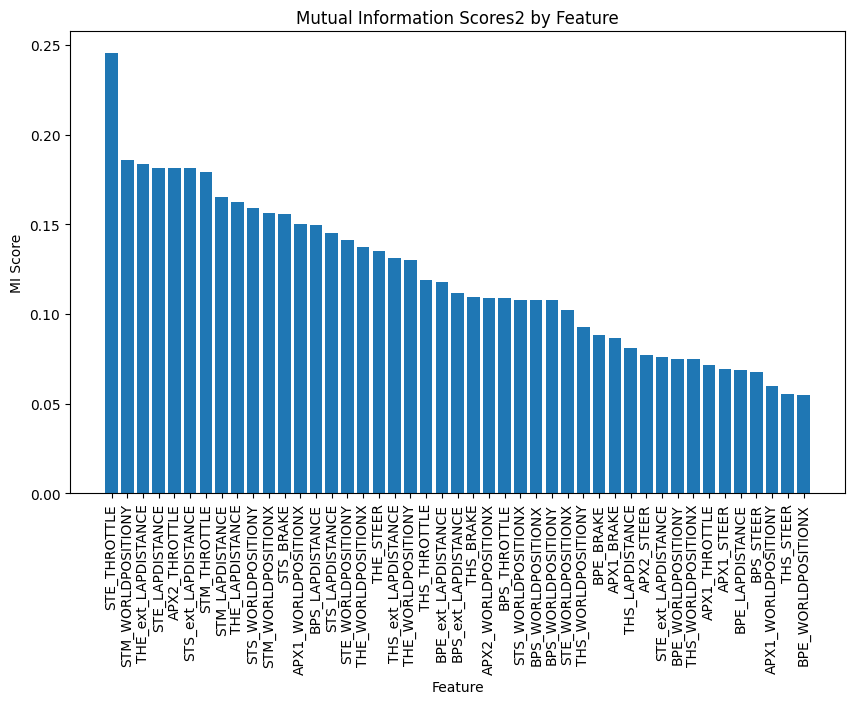

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(Scores2["feature"], Scores2["mi_score"])
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("MI Score")
plt.title("Mutual Information Scores2 by Feature")
plt.show()

# Detecting mutlicollinearity

### Variance inflation factor

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
X = add_constant(X)
vif_data['feature'] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 4) for i in range(X.shape[1])]
vif_data[vif_data["VIF"] < 10].sort_values(by="VIF")#.iloc[:,0]
# vif_data

,feature,VIF
56,APX2_STEER,1.2280
16,THS_STEER,1.3180
43,STE_STEER,1.3964
3,BPS_BRAKE,1.4252
37,STM_STEER,1.4709
22,THE_THROTTLE,1.4841
17,THS_BRAKE,1.4929
2,BPS_STEER,1.5476
57,APX2_BRAKE,1.5691
30,STS_STEER,1.6337


# Modelling

### SVR (scaled data without feature selection and without addressing mutlicollinearity)

In [16]:
poly_parameters = {
    'kernel': ['poly'],
    'degree': [3],
    'gamma': ['scale'],
    'coef0': [3],
    'tol': [1e-03],
    'C': [0.3],
    'epsilon': [0.0005],
    'shrinking': [True],
    'verbose': [True],
    'max_iter': [-1]
}

from sklearn.svm import SVR

grid_poly = GridSearchCV(
    estimator=SVR(),
    param_grid=poly_parameters,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_poly.fit(X_train_scaled, y_train_scaled)
print("Best parameters:", grid_poly.best_params_)
print("Best RMSE:", abs(grid_poly.best_score_))
y_pred_poly_scaled = grid_poly.predict(X_test_scaled)
y_pred_poly = scaler_y_split.inverse_transform(y_pred_poly_scaled.reshape(-1,1))

rmse_poly = root_mean_squared_error(y_pred_poly, y_test)
r2_poly = r2_score(y_pred_poly, y_test)
print("RMSE for poly kernel:", rmse_poly)
print("R² for poly kernel:", r2_poly)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibSVM]Best parameters: {'C': 0.3, 'coef0': 3, 'degree': 3, 'epsilon': 0.0005, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': True}
Best RMSE: 0.9342223750464734
RMSE for poly kernel: 2659.8983926864025
R² for poly kernel: 0.4100719742567558


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LibSVM]Best parameters: {'C': 0.3, 'coef0': 3, 'degree': 3, 'epsilon': 0.0005, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': True}
Best RMSE: 0.549755590951283
RMSE for poly kernel: 1551.693230307914
R² for poly kernel: 0.6867939663481857
2314.67, -0.347

<!-- Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LibSVM]Best parameters: {'C': 0.3, 'coef0': 3, 'degree': 3, 'epsilon': 0.0005, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': True}
Best RMSE: 0.549755590951283
RMSE for poly kernel: 1551.693230307914
R² for poly kernel: 0.6867939663481857 -->

In [17]:
adjusted_r2 = 1 - (1 - r2_poly) * ((len(y) - 1) / (len(y) - X.shape[1] - 1))
MAE = mean_absolute_error(y_pred_poly, y_test)

print(adjusted_r2, MAE)

0.3624089152231956 1163.8432784350166


### CV

In [18]:
fold_rmse = []
fold_R2 = []

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=i+4)
    model = SVR(kernel='poly', degree=3, gamma='scale',
                    coef0=3, tol=1e-3,C=0.1, epsilon=0.0005,
                    shrinking=True, verbose=2,max_iter=-1)
    
    scaler_X_split = StandardScaler()
    scaler_y_split = StandardScaler()
    X_train_scaled = scaler_X_split.fit_transform(X_train)
    X_test_scaled = scaler_X_split.transform(X_test)
    y_train_scaled = scaler_y_split.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y_split.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

    model.fit(X_train_scaled, y_train_scaled)

    y_pred_poly_scaled = model.predict(X_test_scaled)
    y_pred_poly = scaler_y_split.inverse_transform(y_pred_poly_scaled.reshape(-1,1))

    fold_rmse.append(root_mean_squared_error(y_pred_poly, y_test))
    fold_R2.append(r2_score(y_pred_poly, y_test))

print("\n4-fold CV RMSE:")
print("Fold RMSEs:", np.round(fold_rmse, 3))
print("Mean RMSE :", np.round(np.mean(fold_rmse), 3))
print("Std  RMSE :", np.round(np.std(fold_rmse), 3))
print("\n4-fold CV R2:")
print("Fold RMSEs:", np.round(fold_R2, 3))
print("Mean RMSE :", np.round(np.mean(fold_R2), 3))
print("Std  RMSE :", np.round(np.std(fold_R2), 3))

[LibSVM][LibSVM][LibSVM][LibSVM]
4-fold CV RMSE:
Fold RMSEs: [2800.283 3708.039 2550.26  3515.342]
Mean RMSE : 3143.481
Std  RMSE : 481.327

4-fold CV R2:
Fold RMSEs: [-0.273 -0.213 -0.124  0.416]
Mean RMSE : -0.048
Std  RMSE : 0.273


# Finding optimum using model

In [19]:
print(os.getcwd())

c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001\Data3001-Modelling-2


In [20]:
from shapely.geometry import Point,Polygon

os.chdir(r"c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001")
track_left = pd.read_csv("Data3001G2/data/f1sim-ref-left.csv")
track_right = pd.read_csv("Data3001G2/data/f1sim-ref-right.csv")
track_line = pd.read_csv("Data3001G2/data/f1sim-ref-line.csv")
turns = pd.read_csv("Data3001G2/data/f1sim-ref-turns.csv")

track_poly = Polygon(
    np.vstack([
        track_left[['WORLDPOSX', 'WORLDPOSY']].values,
        track_right[['WORLDPOSX', 'WORLDPOSY']].values[::-1]
    ])
)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns[1:])
y_scaled_df = pd.DataFrame(y_scaled, columns=["Target_CURRENTLAPTIMEINMS"])

x_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONX" in c])
y_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONY" in c])

def sampling(bounds, N, rng, x_cols, y_cols):
    xy_pairs = list(zip(x_cols, y_cols))
    valid = []

    while len(valid) < N:
        cand_idx = rng.integers(0, len(X_scaled_df))
        cand = X_scaled_df.iloc[cand_idx].to_dict()

        all_inside = True
        for xc, yc in xy_pairs:
            x = cand[xc]
            y = cand[yc]

            if not track_poly.contains(Point(x, y)):
                all_inside = False
                break
        if all_inside:
            valid.append(cand)
    return pd.DataFrame(valid)

In [21]:
percentiles = (0, 0.999999)

bounds = {
    f: (X_scaled_df[f].quantile(percentiles[0]),
        X_scaled_df[f].quantile(percentiles[1]))
    for f in X_scaled_df.columns
}

rng = np.random.default_rng(42)
N = 5000

Xcand = sampling(bounds, N, rng, x_cols, y_cols)
Xcand = Xcand[X_scaled_df.columns]

ycand = grid_poly.predict(Xcand)
ycand_unscaled = scaler_y.inverse_transform(ycand.reshape(-1, 1)).ravel()

imin = int(np.argmin(ycand_unscaled))
best_combo_scaled = Xcand.iloc[imin].to_frame().T
best_combo_unscaled = pd.DataFrame(
    scaler_X.inverse_transform(best_combo_scaled),
    columns=X.columns[1:]
)

best_pred = ycand_unscaled[imin]

print("\n=== SVR-suggested first-brake setup (within observed range) ===")
for k, v in best_combo_unscaled.iloc[0].items():
    print(f"{k}: {v:,.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f}")



=== SVR-suggested first-brake setup (within observed range) ===
BPS_THROTTLE: 1.0000
BPS_STEER: -0.0019
BPS_BRAKE: 0.0000
BPS_LAPDISTANCE: 278.0000
BPS_WORLDPOSITIONX: 313.7286
BPS_WORLDPOSITIONY: 275.4056
BPS_ext_LAPDISTANCE: 294.0000
BPE_THROTTLE: 0.0000
BPE_STEER: 0.2185
BPE_BRAKE: 0.9926
BPE_LAPDISTANCE: 345.0000
BPE_WORLDPOSITIONX: 360.3163
BPE_WORLDPOSITIONY: 227.1598
BPE_ext_LAPDISTANCE: 360.0000
THS_THROTTLE: 0.9747
THS_STEER: -0.0015
THS_BRAKE: 0.0870
THS_LAPDISTANCE: 284.0000
THS_WORLDPOSITIONX: 318.0981
THS_WORLDPOSITIONY: 271.2897
THS_ext_LAPDISTANCE: 306.0000
THE_THROTTLE: 0.1264
THE_STEER: 0.2417
THE_BRAKE: 0.0000
THE_LAPDISTANCE: 368.0000
THE_WORLDPOSITIONX: 371.9679
THE_WORLDPOSITIONY: 206.1569
THE_ext_LAPDISTANCE: 426.0000
STS_THROTTLE: 0.3867
STS_STEER: 0.0095
STS_BRAKE: 1.0000
STS_LAPDISTANCE: 296.0000
STS_WORLDPOSITIONX: 326.8420
STS_WORLDPOSITIONY: 263.0630
STS_ext_LAPDISTANCE: 380.0000
STM_THROTTLE: 1.0000
STM_STEER: 0.0007
STM_BRAKE: 0.0000
STM_LAPDISTANCE: 428.

c:\Users\Haseeb Ijaz\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


=== SVR-suggested first-brake setup (within observed range) ===
BPS_THROTTLE: 1.0000
BPS_STEER: -0.0019
BPS_BRAKE: 0.0000
BPS_LAPDISTANCE: 278.0000
BPS_WORLDPOSITIONX: 313.7286
BPS_WORLDPOSITIONY: 275.4056
BPS_ext_LAPDISTANCE: 294.0000
BPE_THROTTLE: 0.0000
BPE_STEER: 0.2185
BPE_BRAKE: 0.9926
BPE_LAPDISTANCE: 345.0000
BPE_WORLDPOSITIONX: 360.3163
BPE_WORLDPOSITIONY: 227.1598
BPE_ext_LAPDISTANCE: 360.0000
THS_THROTTLE: 0.9747
THS_STEER: -0.0015
THS_BRAKE: 0.0870
THS_LAPDISTANCE: 284.0000
THS_WORLDPOSITIONX: 318.0981
THS_WORLDPOSITIONY: 271.2897
THS_ext_LAPDISTANCE: 306.0000
THE_THROTTLE: 0.1264
THE_STEER: 0.2417
THE_BRAKE: 0.0000
THE_LAPDISTANCE: 368.0000
THE_WORLDPOSITIONX: 371.9679
THE_WORLDPOSITIONY: 206.1569
THE_ext_LAPDISTANCE: 426.0000
STS_THROTTLE: 0.3867
STS_STEER: 0.0095
STS_BRAKE: 1.0000
STS_LAPDISTANCE: 296.0000
STS_WORLDPOSITIONX: 326.8420
STS_WORLDPOSITIONY: 263.0630
STS_ext_LAPDISTANCE: 380.0000
STM_THROTTLE: 1.0000
STM_STEER: 0.0007
STM_BRAKE: 0.0000
STM_LAPDISTANCE: 428.0000
STM_WORLDPOSITIONX: 374.0646
STM_WORLDPOSITIONY: 153.2781
STE_THROTTLE: 1.0000
STE_STEER: -0.0000
STE_BRAKE: 0.0000
STE_LAPDISTANCE: 613.7559
STE_WORLDPOSITIONX: 433.0757
STE_WORLDPOSITIONY: -6.3987
STE_ext_LAPDISTANCE: 477.0000
APX1_THROTTLE: 0.2882
APX1_STEER: 0.3802
APX1_BRAKE: 0.0000
APX1_LAPDISTANCE: 387.0000
APX1_WORLDPOSITIONX: 375.8798
APX1_WORLDPOSITIONY: 191.7831
APX2_THROTTLE: 1.0000
APX2_STEER: -0.1702
APX2_BRAKE: 0.0000
APX2_LAPDISTANCE: 495.0000
APX2_WORLDPOSITIONX: 369.1078
APX2_WORLDPOSITIONY: 90.1388
Predicted Target_CURRENTLAPTIMEINMS: 12,086.059
c:\Users\Haseeb Ijaz\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(

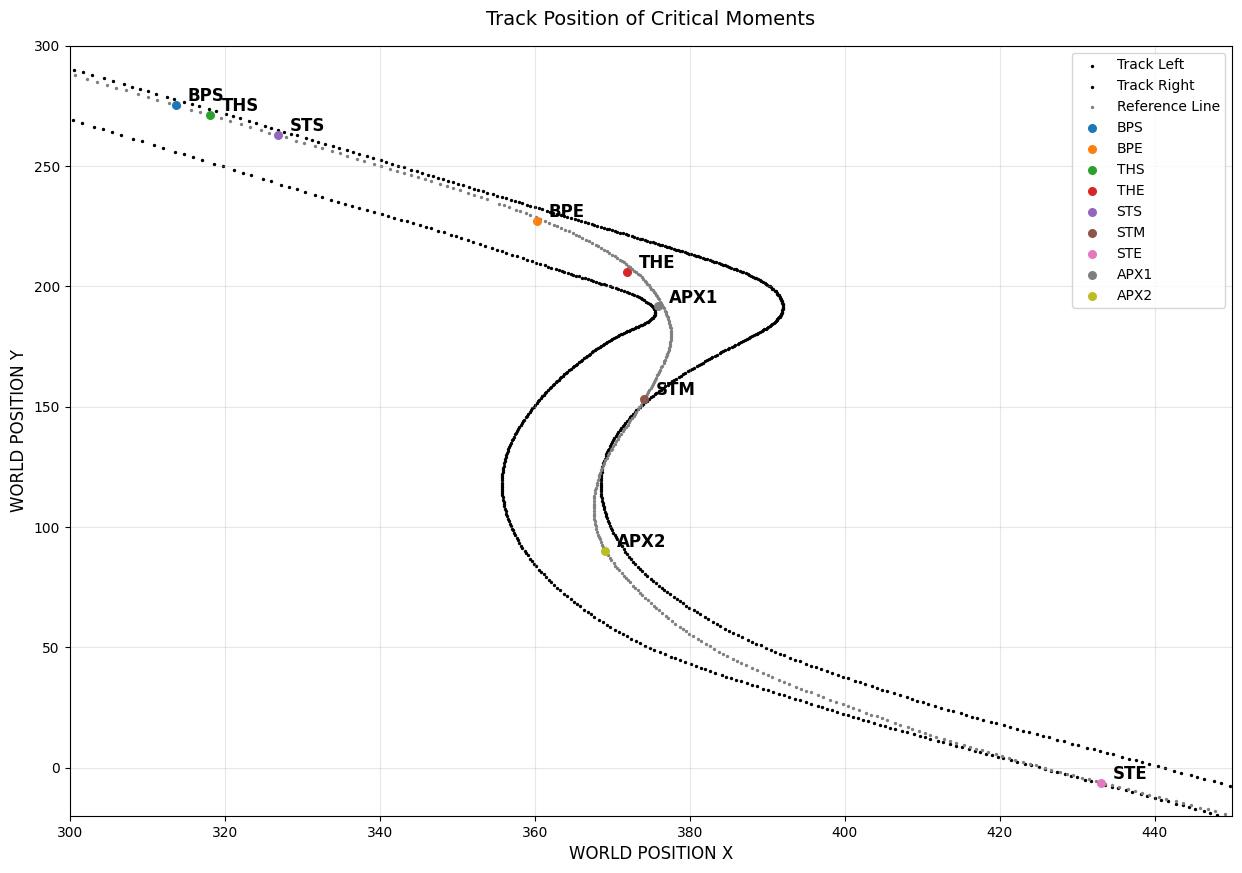

In [22]:
import matplotlib.pyplot as plt

points = {}

prefixes = ["BPS", "BPE", "THS", "THE", "STS", "STM", "STE", "APX1", "APX2"]

row = best_combo_unscaled.iloc[0]
for p in prefixes:
    x_col = f"{p}_WORLDPOSITIONX"
    y_col = f"{p}_WORLDPOSITIONY"
    
    if x_col in row and y_col in row:
        points[p] = (float(row[x_col]), float(row[y_col]))

plt.figure(figsize=(15, 10))
f = 100000

plt.scatter(track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSX"],
            track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right.loc[track_right["FRAME"] <= f, "WORLDPOSX"],
            track_right.loc[track_right["FRAME"] <= f, "WORLDPOSY"],
            s=2, color="black", label="Track Right")
plt.scatter(track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSX"],
            track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="gray",  label="Reference Line")

for name, (x, y) in points.items():
    plt.scatter(x, y, s=30, label=name)
    plt.text(x + 1.5, y + 1.5, name, fontsize=12, weight="bold")

plt.xlabel("WORLD POSITION X", fontsize=12)
plt.ylabel("WORLD POSITION Y", fontsize=12)
plt.title("Track Position of Critical Moments", fontsize=14, pad=15)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(300, 450)
plt.ylim(-20, 300)
plt.show()


# Partial Poly Graph

- do partial poly graph

- try and get optimum line


c:\Users\Haseeb Ijaz\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


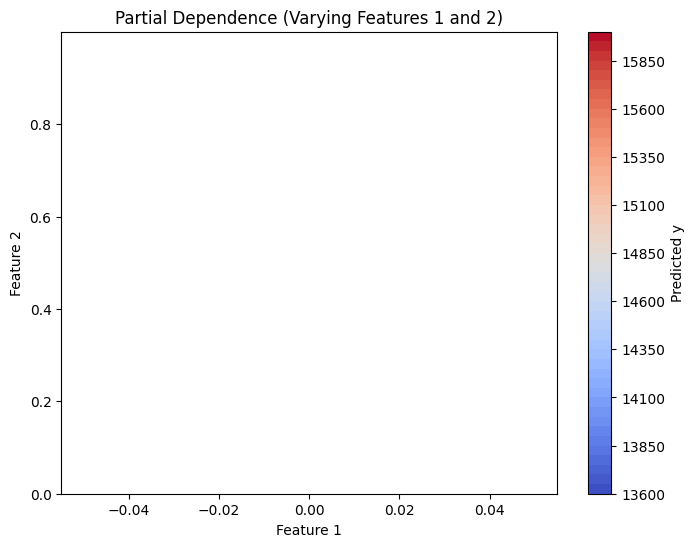

IndexError: tuple index out of range

In [25]:
X_np = X_np = X.iloc[:, 1:].to_numpy()

for i in range(X_np.shape[1]):
    for j in range(i + 1, X_np.shape[1]):

        feature1_range = np.linspace(0, percentiles[i], 100)
        feature2_range = np.linspace(0, percentiles[j], 100)

        feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)

        X_grid = np.vstack([feature1_grid.ravel(), feature2_grid.ravel()]).T

        other_idx = [k for k in range(X_np.shape[1]) if k != i and k != j]
        X_fixed = np.mean(X_np[:, other_idx], axis=0)   # <-- FIXED

        X_fixed_repeat = np.tile(X_fixed, (X_grid.shape[0], 1))

        X_combined = np.hstack([X_grid, X_fixed_repeat])

        X_combined_scaled = scaler_X.transform(X_combined)
        y_pred_scaled = grid_poly.predict(X_combined_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))

        y_pred_grid = y_pred.reshape(feature1_grid.shape)

        plt.figure(figsize=(8, 6))
        plt.contourf(feature1_range, feature2_range, y_pred_grid, levels=50, cmap='coolwarm')
        plt.colorbar(label='Predicted y')
        plt.title(f'Partial Dependence (Varying Features {i+1} and {j+1})')
        plt.xlabel(f'Feature {i+1}')
        plt.ylabel(f'Feature {j+1}')
        plt.show()
